# Big Data and Machine Learning - CW5

Code written by Dafydd-Rhys Maund - 200900

## Task

This code simply is to achieve the following requirements

- Load data and labels
- shuffle the data set samples and divide them into 80% train, 10% validation and 10% test samples
- Apply Machine Learning algorithms to classify the land cover in an image.
  - 1 Classification/Clustering
  - Same Model + Dimenstio Reduction Method or HoG
  - CNN Classification

### Data Preperation

#### Import libraries

Importing the libraries needed for the CW

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from google.colab import drive

#### Load datasets

This fetches and loads the file from and using Google Drive

In [174]:
drive.mount('/content/drive')

X_file = '/content/drive/My Drive/MLCoursework/datasets/DS_Xdata.npy'
Y_file = '/content/drive/My Drive/MLCoursework/datasets/Ydata.npy'

X = np.load(X_file)
y = np.load(Y_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Shuffle and split data

Splits the data and inherently shuffles.

In [175]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

num_classes = len(np.unique(y))

y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

### Model 1: SVM

#### Apply SVM

Selects 5 classes as wanted, then flattens the Y to be suitable. Then it simply trains the SVM model with the passed raw data and creates a prediction.

In [176]:
selected_classes = [0, 1, 2, 3, 4]
y = y.ravel()  # Ensure y is a 1D array

mask = np.isin(y, selected_classes)
X_svm = X[mask]
y_svm = y[mask]

X_svm_flat = X_svm.reshape(X_svm.shape[0], -1)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm_flat, y_svm, test_size=0.2, random_state=42, stratify=y_svm
)

svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_svm, y_train_svm)
y_pred_svm = svm_model.predict(X_test_svm)

#### Accuracy

Calculaltes and outputs the accuracy of the standalone SVM model.

In [177]:
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f"Accuracy of SVM Classifier: {accuracy_svm * 100:.2f}%")

Accuracy of SVM Classifier: 82.00%


#### Evaluate and Visualise

Visualises the results in format of confusion matrix, all values of the diagonal are misclassifications.

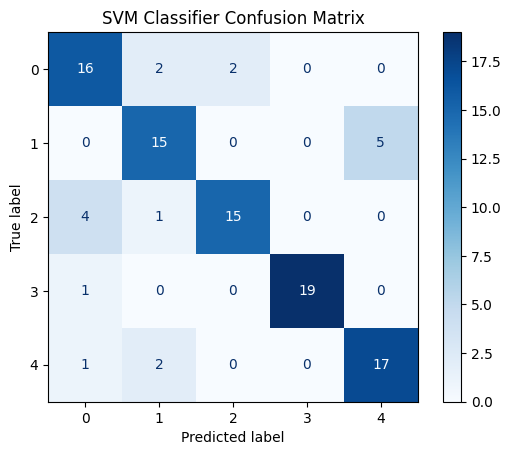

In [178]:
confusion_svm = confusion_matrix(y_test_svm, y_pred_svm)
ConfusionMatrixDisplay(confusion_matrix=confusion_svm, display_labels=selected_classes).plot(cmap=plt.cm.Blues)
plt.title("SVM Classifier Confusion Matrix")
plt.show()

### Model 2: SVM + HoG

#### Obtain HoG features

Applies HoG feature extraction to the images of the classes, then converts them to numPy array.

In [179]:
all_hog_features = []
hog_labels = []

for i in range(X.shape[0]):
    if y[i] in selected_classes:  # Only process selected classes
        image = X[i, :, :, :]  # Extract the image
        hog_feature, _ = skimage.feature.hog(image,
                                             pixels_per_cell=[8, 8],
                                             cells_per_block=[2, 2],
                                             visualize=True,
                                             channel_axis=2)
        all_hog_features.append(hog_feature)
        hog_labels.append(y[i])

all_hog_features = np.array(all_hog_features)
hog_labels = np.array(hog_labels)

#### Apply SVM using HoG

Then runs SVM using the HoG features as an input.

In [180]:
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(
    all_hog_features, hog_labels, test_size=0.2, random_state=42, stratify=hog_labels
)

svm_hog_model = SVC(kernel='rbf', random_state=42)
svm_hog_model.fit(X_train_hog, y_train_hog)

y_pred_hog_svm = svm_hog_model.predict(X_test_hog)

#### Accuracy

Calculates and outputs the accuracy of the model.

In [181]:
accuracy_hog_svm = accuracy_score(y_test_hog, y_pred_hog_svm)
print(f"Accuracy of HoG + SVM Classifier: {accuracy_hog_svm * 100:.2f}%")

Accuracy of HoG + SVM Classifier: 91.00%


#### Evaluate and Visualise

Visualises the results using confusion matrix.

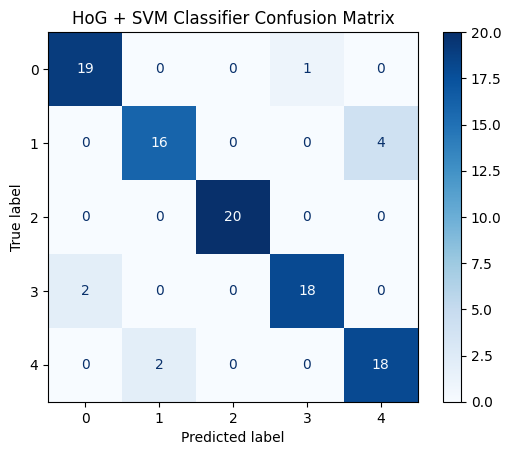

In [182]:
confusion_hog_svm = confusion_matrix(y_test_hog, y_pred_hog_svm)
ConfusionMatrixDisplay(confusion_matrix=confusion_hog_svm, display_labels=selected_classes).plot(cmap=plt.cm.Blues)
plt.title("HoG + SVM Classifier Confusion Matrix")
plt.show()

### Model 3: CNN

#### Create and compile model

Creates and compiles a CNN model, it uses the Adam optimiser and categorical crossen tropy. Also, uses dropout to deal with overfitting.

In [183]:
cnn_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Train and evaluate the model

Trains the model across 10 epochs, outputting the accuracy and loss of both the training and validation set.

In [184]:
history = cnn_model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat))

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 583ms/step - accuracy: 0.0692 - loss: 14.9084 - val_accuracy: 0.1762 - val_loss: 2.6911
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 574ms/step - accuracy: 0.1838 - loss: 2.6526 - val_accuracy: 0.2619 - val_loss: 2.4938
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 574ms/step - accuracy: 0.2941 - loss: 2.3513 - val_accuracy: 0.3619 - val_loss: 2.1766
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 570ms/step - accuracy: 0.3860 - loss: 2.0118 - val_accuracy: 0.4143 - val_loss: 1.8025
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 575ms/step - accuracy: 0.4797 - loss: 1.7291 - val_accuracy: 0.4952 - val_loss: 1.7722
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 579ms/step - accuracy: 0.6034 - loss: 1.3148 - val_accuracy: 0.5190 - val_loss: 1.7121
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 591ms/step - accuracy: 0.6353 - loss: 1.1542 - val_accuracy: 0.5095 - val_loss: 1.7022
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 557ms/step - accuracy: 0.7198 - loss: 0.9456 - val_acc

#### Visualise the Results (Curve)

Outputs the accuracy of the CNN classifier and shows the training curve, showing accuracy over epochs.

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.5897 - loss: 1.6142
Accuracy of CNN Classifier: 60.95%


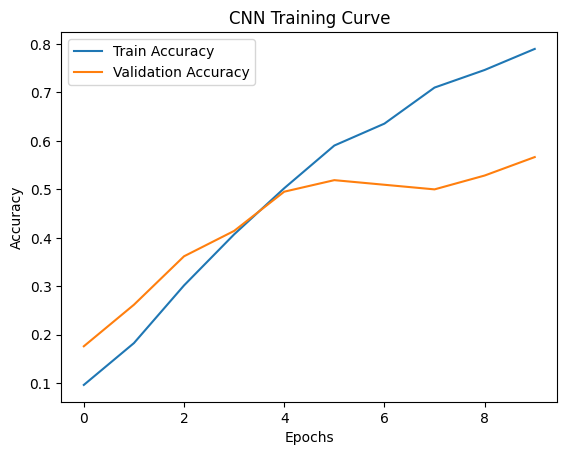

In [185]:
accuracy_cnn = cnn_model.evaluate(X_test, y_test_cat)[1]
print(f"Accuracy of CNN Classifier: {accuracy_cnn * 100:.2f}%")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("CNN Training Curve")
plt.show()

#### Visualise the Results (Confusion Matrix)

Visualises the results in the form of confusions matrix, showing all the misclassifications

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


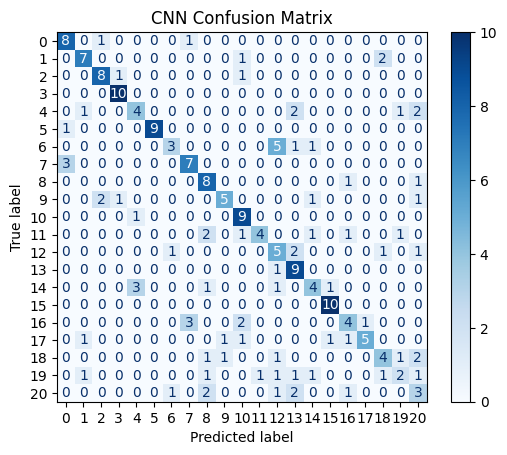

In [186]:
y_test_pred = np.argmax(cnn_model.predict(X_test), axis=1)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred)).plot(cmap=plt.cm.Blues)
plt.title("CNN Confusion Matrix")
plt.show()